# Aplicación n-gramas: generación de frases «mañaneras»


Equipo 4:

ALONDRA KAROLINA MONTAÑO PRECIADO

RUBEN RAMON ROMERO BELTRAN

JORGE ANDRES RASCON ACUÑA


Recursos utilizados en este proyecto:

"Conferencias Matutinas del Presidente Andres Manuel López Obrador ( Mañaneras AMLO )" por NOSTRODATA obtenido de https://github.com/NOSTRODATA/conferencias_matutinas_amlo licenciado bajo CC BY-NC-SA 4.0

Exploratory Data Analysis for Natural Language Processing: A Complete Guide to Python Tools https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

NLTK Documentation https://www.nltk.org/api/nltk.lm.html

Usando la transcripción de multiples mañaneras del Presidente Andres Manuel López Obrador, formaremos un algoritmo que cree una frase nueva que parezca real o (al menos) coherente.

## Libreta 1: Obtención de Datos

In [ ]:
# Utilerīa de Conexión a Google Drive
from google.colab import drive

# Montamos carpeta de Drive al entorno local
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Utilerīa para descomprimir archivos
import zipfile

# Descomprimimos y extraemos todos los archivos del .zip
#   a una nueva carpeta llamada conferencias
archivo = "drive/MyDrive/conferencias_matutinas_amlo-master.zip"
with zipfile.ZipFile(archivo, 'r') as zip_ref:
    zip_ref.extractall("conferencias")

In [ ]:
# Módulo de sistema operativo
import os

archivos = []
nombre_archivo = "PRESIDENTE ANDRES MANUEL LOPEZ OBRADOR.csv"
# Atravesamos la carpeta conferencias buscando archivos con el nombre
#   indicado en la variable 'nombre_archivo', guardamos las rutas a todos
#   los archivos en el arreglo 'archivos'
for root, dirs, files in os.walk("conferencias"):
  for file in files:
    if file == nombre_archivo:
      archivos.append(os.path.join(root, file))

In [ ]:
# Utilerīa para manipular archivos csv
import csv

lineas_csv = []
# Por cada ruta de archivo encontrada, abrimos el archivo como csv y
#   guardamos cada linea del csv en el arreglo 'lineas_csv'
for ar in archivos:
  with open(ar, mode ='r') as file:
    csvFile = csv.reader(file)
    for lines in csvFile:
      lineas_csv.append(lines)

In [ ]:
# Utilerīa de expresiones regulares
import re

# Abrimos (se crea si no existe) el archivo corpus.txt en modo escritura.
with open('corpus.txt','w') as file:
  # Escribimos encabezado del archivo servirá para pandas
  file.write("Enunciados\n")
  # Iteramos todas las lineas guardadas en formato csv de todos
  #   los archivos previamente leidos
  for linea_csv in lineas_csv:
    # Escribimos al archivo corpus.txt, todos los enunciados atribuidos
    #   al nombre de etiqueta del presidente
    etiqueta = 'PRESIDENTE ANDRES MANUEL LOPEZ OBRADOR'
    if (linea_csv[0] == etiqueta):
      # Regex para quitar los ':'
      line = re.sub(r": ", "", linea_csv[1]) + "\n"
      file.write(line)

In [ ]:
# Solo es para verificar el formato de corpus.txt

# Abrimos y leemos las primeras 'n' lineas de corpus.txt
with open('corpus.txt','r') as file:
  for i in range(5):
    print(file.readline())

Enunciados

 Buenos días.

Bueno, vamos a informar sobre la salud, como lo hacemos todos los martes, y también vamos a informar sobre las acciones para erradicar la violencia contra las mujeres, como corresponde también de manera periódica, cada mes nos toca informar sobre este importante tema.

Entonces, vamos con el doctor Jorge Alcocer. Empezamos.

También, antes de iniciar, continuamos con las comparecencias de los candidatos a la secretaría general del sindicato de Pemex, corresponde a cinco candidatas y candidatos exponer a partir de las ocho y media. Pero antes de las ocho y media, si terminan las compañeras, los compañeros, tenemos un tiempo para preguntas y respuestas.



## Libreta 2: Preparación de los datos para el entrenamiento

Estadisticas del texto

<AxesSubplot:>

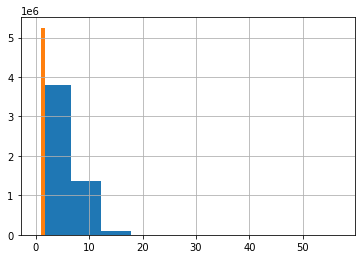

In [ ]:
# Utilería para manejar datos
import pandas as pd

df = pd.read_table("corpus.txt", delimiter="\n")
df.dropna(inplace = True)

enunciados_lst = df['Enunciados'].tolist()
palabras_lst = ' '.join(enunciados_lst).split(' ')
palabras_lst = list(filter(None, palabras_lst))
corpus = pd.DataFrame(palabras_lst, columns=['Palabras'])

corpus['Palabras'].str.len().hist()
corpus['Palabras'].str.split().map(lambda x: len(x)).hist()


In [ ]:
# Utilería para procesamiento de lenguaje natural
import nltk
from nltk.corpus import stopwords

# Descargamos diccionario de stopwords
#   y setteamos el idioma a español
nltk.download('stopwords')
stop = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<BarContainer object of 10 artists>

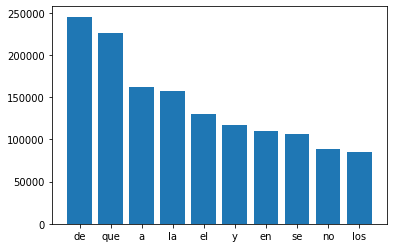

In [ ]:
# Utilería para graficar datos
import matplotlib.pyplot as plt
# Utilería para estructurar diccionarios
from collections import defaultdict

# corpus = []
dic = defaultdict(int)
new = corpus['Palabras'].str.split()
new = new.values.tolist()
corpus_list = [word for i in new for word in i]

for word in corpus_list:
    if word in stop:
        dic[word] += 1

top = sorted(dic.items(), key = lambda x: x[1], reverse = True)[:10] 
x, y = zip(*top)
plt.bar(x, y)

<AxesSubplot:>

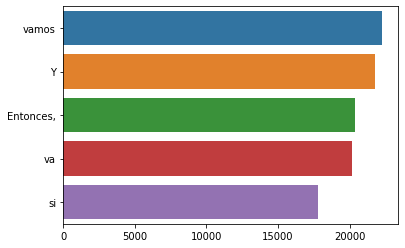

In [ ]:
# Utilería para estructurar contador de la coleccion
from collections import Counter
# Utilería para graficar
import seaborn as sns

counter = Counter(corpus_list)
most = counter.most_common()

x, y = [], []
for word,count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)

sns.barplot(x = y, y = x)

Exploración de ngramas

In [ ]:
# Utilería para contar elementos vectorizados
from sklearn.feature_extraction.text import CountVectorizer

def calcular_ngramas(n):
  vec = CountVectorizer(ngram_range=(n, n)).fit(corpus_list)
  bag_of_words = vec.transform(corpus_list)
  sum_words = bag_of_words.sum(axis=0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
  return words_freq[:10]

unigram_results = calcular_ngramas(1);
bigram_results = calcular_ngramas(2);

x,y = map(list,zip(*unigram_results))
sns.barplot(x = y,y = x)

x,y = map(list,zip(*bigram_results))
sns.barplot(x = y,y = x)

## Libreta 3: Entrenamiento de modelos

In [ ]:
print(unigram_results[:5])
print(bigram_results[:5])

[('de', 248374), ('que', 231425), ('la', 161964), ('el', 136409), ('en', 115915)]
[('lópez gatell', 316), ('imss bienestar', 182), ('dn iii', 107), ('lópez dóriga', 96), ('dicen no', 88)]


In [ ]:
import nltk
from nltk.probability import FreqDist, ConditionalFreqDist
import random
from collections import Counter

bigrams = nltk.bigrams(corpus_list)
cfd = ConditionalFreqDist(bigrams)
seed_text = random.choice(corpus_list)
generated_text = seed_text

# Generador de texto por frecuencia distribuida condicional
for i in range(10):
    next_word = cfd[seed_text].max()
    generated_text += " " + next_word
    seed_text = next_word
print(generated_text + ".")

Le voy a la gente que se va a la gente.


In [ ]:
# vectoriza el texto a tuplas de 3 elementos
def markov_triples(words):
  for i in range(len(words) - 2):
        yield (words[i], words[i+1], words[i+2])

cache = {}
word_size = len(corpus_list)

# recorremos las tuplas y vectorizamos en una nueva llave
# los primeros dos elementos, para crear efecto de recorrimiento
for w1, w2, w3 in markov_triples(corpus_list):
      key = (w1, w2)
      if key in cache:
        cache[key].append(w3)
      else:
        cache[key] = [w3]

# funcion de generacion de texto por medio de markov
def generate_markov_text(size = 10):
    seed = random.randint(0, word_size - 3)
    seed_word, next_word = corpus_list[seed], corpus_list[seed + 1]
    w1, w2 = seed_word, next_word
    gen_words = []
    for i in range(size):
      gen_words.append(w1)
      w1, w2 = w2, random.choice(cache[(w1, w2)])
    gen_words.append(w2)
    return ' '.join(gen_words)

somos independientes y no por gusto. Pero fíjense, qué bien me


In [ ]:
print(generate_markov_text(8))
print(generate_markov_text(16))
print(generate_markov_text(20))

posibilidad de expresarnos. Cuando yo termine -si me iban
Mira la importancia que tienen los contenidos, porque también ahí está la política si no iba ser
de gente muy esperanzada. Y no sé si tienes, porque se va a haber 21 sucursales, son muy buenos, ¿eh?, muy


In [ ]:
%%shell
jupyter nbconvert --to html /content/Frases_AMLO.ipynb

[NbConvertApp] Converting notebook /content/Frases_AMLO.ipynb to html
[NbConvertApp] Writing 639613 bytes to /content/Frases_AMLO.html
